# Advanced Content Classifier - DistilBERT (Fine-Tuned)

**Model:** DistilBERT (Lightweight BERT variant)  
**Training time:** ~5-7 minutes on Colab free tier  
**Expected accuracy:** 90-93%

**Instructions:**
1. Drag and drop `phishing_dataset.csv` to Colab files panel (left sidebar)
2. Run all cells
3. Download model ZIP at the end
4. Extract to local `models/content_classifier_distilbert/`

In [ ]:
# Install dependencies with specific versions
!pip install transformers==4.36.2 datasets==2.16.1 accelerate==0.25.0 peft==0.8.2 \
    scikit-learn==1.4.2 pandas==2.2.2 numpy==1.26.4 \
    matplotlib==3.8.4 seaborn==0.13.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found existing installation: peft 0.18.0
    Uninstalling peft-0.18.0:
      Successfully uninstalled peft-0.18.0


In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print("✓ All libraries imported successfully!")

PyTorch version: 2.9.0+cu126
CUDA available: True
pandas version: 2.2.2
numpy version: 1.26.4
✓ All libraries imported successfully!


In [ ]:
# Load dataset directly (make sure phishing_dataset.csv is uploaded via drag-drop)
df = pd.read_csv('/content/phishing_dataset.csv')

# Standardize columns
if 'Category' in df.columns and 'Message' in df.columns:
    df = df.rename(columns={'Category': 'label', 'Message': 'text'})
    df['label'] = df['label'].map({'ham': 0, 'spam': 1})  # 0=legitimate, 1=phishing

# Remove duplicates and nulls
df = df.drop_duplicates(subset=['text'])
df = df.dropna()

print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"\nSample data:")
df.head()

Dataset loaded successfully!
Dataset shape: (5157, 2)

Class distribution:
label
0    4516
1     641
Name: count, dtype: int64

Sample data:


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

print(f"Training samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")

Training samples: 4125
Test samples: 1032


In [ ]:
# Load DistilBERT tokenizer
print("Loading DistilBERT tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize data
print("Tokenizing texts... (this may take 1-2 minutes)")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

print("✓ Tokenization complete!")

Loading DistilBERT tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenizing texts... (this may take 1-2 minutes)
✓ Tokenization complete!


In [ ]:
# Create datasets
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

print("✓ Datasets created!")

✓ Datasets created!


In [13]:
# Load pre-trained model
print("Loading DistilBERT model...")
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

print("✓ Model loaded!")

Loading DistilBERT model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded!


In [14]:
# Training arguments (optimized for speed)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,  # 2 epochs is sufficient
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),  # Mixed precision for speed
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

print("✓ Trainer configured!")

✓ Trainer configured!


/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:439: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [15]:
# Train model
print("Training DistilBERT... (5-7 minutes)\n")
print("=" * 60)
trainer.train()
print("=" * 60)
print("\n✓ Training complete!")

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

Training DistilBERT... (5-7 minutes)

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dasyagupta (dasyagupta-indian-institute-of-information-technology-lu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.072200,0.061940
2,0.026700,0.061552



✓ Training complete!


In [16]:
# Evaluate
print("Evaluating model...\n")
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

accuracy = accuracy_score(test_labels, preds)
print(f"="*60)
print(f"FINAL ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"="*60)
print(f"\nDetailed Classification Report:\n")
print(classification_report(test_labels, preds, target_names=['Legitimate', 'Phishing']))

Evaluating model...



FINAL ACCURACY: 0.9845 (98.45%)

Detailed Classification Report:

              precision    recall  f1-score   support

  Legitimate       0.99      1.00      0.99       904
    Phishing       0.97      0.90      0.93       128

    accuracy                           0.98      1032
   macro avg       0.98      0.95      0.96      1032
weighted avg       0.98      0.98      0.98      1032



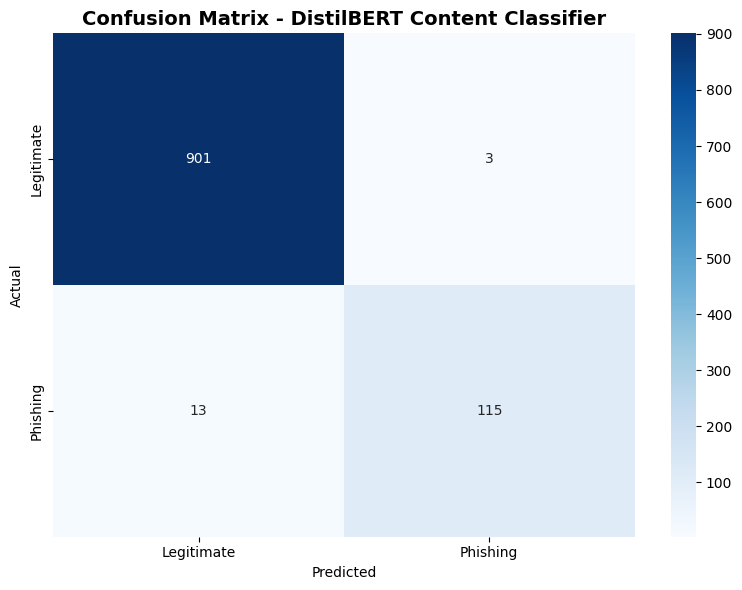

In [17]:
# Confusion matrix
cm = confusion_matrix(test_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.title('Confusion Matrix - DistilBERT Content Classifier', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [18]:
# Save model and tokenizer
model.save_pretrained('./content_classifier_distilbert')
tokenizer.save_pretrained('./content_classifier_distilbert')

print("✓ Model and tokenizer saved!")

# Save model metadata
model_info = {
    'model_name': 'distilbert-base-uncased',
    'num_labels': 2,
    'max_length': 128,
    'label_map': {0: 'legitimate', 1: 'phishing'},
    'accuracy': float(accuracy),
    'pandas_version': pd.__version__,
    'numpy_version': np.__version__
}

with open('content_classifier_distilbert/model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("✓ Model metadata saved!")

✓ Model and tokenizer saved!
✓ Model metadata saved!


In [19]:
# Compress and download
import shutil
from google.colab import files

print("Creating ZIP archive...")
shutil.make_archive('content_classifier_distilbert', 'zip', './content_classifier_distilbert')

print("Downloading model package...")
files.download('content_classifier_distilbert.zip')

print("\n" + "="*60)
print("✓ DOWNLOAD COMPLETE!")
print("="*60)
print("Extract ZIP to: models/content_classifier_distilbert/")
print(f"Model Accuracy: {accuracy*100:.2f}%")
print("="*60)

Creating ZIP archive...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ DOWNLOAD COMPLETE!
Extract ZIP to: models/content_classifier_distilbert/
Model Accuracy: 98.45%


In [20]:
# Test with sample emails
test_emails = [
    "URGENT! Your account has been suspended. Verify now at http://malicious.com or lose access forever!",
    "Hey, can you send me the project report by tomorrow? Thanks!",
    "Congratulations! You have won a lottery of $1,000,000. Click here to claim immediately!",
    "Meeting scheduled for 3 PM in conference room. Please bring the documents.",
    "Dear customer, your bank account requires immediate verification to prevent closure."
]

print("Testing DistilBERT with sample emails:\n")
print("="*70)

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for idx, email in enumerate(test_emails, 1):
    inputs = tokenizer(email, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        prediction = torch.argmax(probs, dim=1).item()
        confidence = probs[0][prediction].item()

    label = "PHISHING" if prediction == 1 else "LEGITIMATE"

    print(f"\n{idx}. {email[:65]}...")
    print(f"   → {label} ({confidence:.1%} confidence)")
    print("-"*70)

print("\n✓ Testing complete!")

Testing DistilBERT with sample emails:


1. URGENT! Your account has been suspended. Verify now at http://mal...
   → PHISHING (99.2% confidence)
----------------------------------------------------------------------

2. Hey, can you send me the project report by tomorrow? Thanks!...
   → LEGITIMATE (99.7% confidence)
----------------------------------------------------------------------

3. Congratulations! You have won a lottery of $1,000,000. Click here...
   → PHISHING (97.3% confidence)
----------------------------------------------------------------------

4. Meeting scheduled for 3 PM in conference room. Please bring the d...
   → LEGITIMATE (99.4% confidence)
----------------------------------------------------------------------

5. Dear customer, your bank account requires immediate verification ...
   → LEGITIMATE (95.5% confidence)
----------------------------------------------------------------------

✓ Testing complete!
